<a href="https://colab.research.google.com/github/seedatnabeel/Pygotham2019_GANS/blob/master/GAN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks



## Generative Adversarial Networks



At Pygotham 2019 -  this tutorial will introduce deep generative modelling specifically Generative Adversarial Networks (GANs)

We will learn the following:
* What is a GAN and how does it work
* What makes it hard to train GANs
* Tips and Tricks to make it easier to train GANs
* Get your hands dirty and train a GAN to generate pictures of clothes
* Links to resources to help you along your GAN journey


**NOTE**
Please enable the GPU on Google Colab to speed up training. Runtime ---> Change runtime type ---> Under hardware accelerator select GPU




[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs), are a very popular class of deep generative models which have shown some incredible results in generating images. For example, take a look at the progress that has been made in generating pictures of people's faces, taken from Ian Goodfellow's [twitter](https://www.google.com/url?q=https://twitter.com/goodfellow_ian/status/1084973596236144640&sa=D&ust=1565613603406000&usg=AFQjCNEtcXzfgDqPL0vPBkDJhl-x2Iup_Q_):

![faces](https://pbs.twimg.com/media/Dw6ZIOlX4AMKL9J.jpg)

The idea behind GANs is to train two networks simultaneously. Firstly, a **generator network**, which we can train to take a random input (often called $z$) and produce a sample from some distribution, in this case, the distribution of 28 x 28 grayscale clothing images. Secondly, we have a **discriminator network**, which will learn to tell apart the real (training) data and the fake (generated) data. The generator is trained to trick the discriminator and the discriminator is trained to avoid being tricked. This process is described in the following diagram:

![GAN](https://i.imgur.com/OUPd4Av.png)

As you can see in the above diagram, the discriminator's loss is calculated from using the labels (real or fake) for the generated and training images. We can use the standard cross-entropy loss function for a binary classifier. However, more interestingly, the generator's loss comes from performing back-propagation through the discriminator. In a sense, **the discriminator is the loss function for the generator**. While it may seem strange to train a neural network using another neural network as the loss function, rather than some pre-defined function, it turns out that training this way approximately minimizes something called the Jensen-Shannon divergence (JSD), which is a well motivated choice of loss function for generative models that we would be unable to calculate analytically.


**Why would we want to do this? Some cool applications**

Regarding our task of generating images, you may be wondering why we care about doing this! One simple reason we're spending time on this is that it is a fun application of generative models, which gives us an excellent visual way of exploring how different models work. However, generating images itself has many interesting applications ranging from creating new fonts to making people smile in pictures, and from assisting with interactive design to creating photo-realistic images from drawn outlines (see [this cool article](https://distill.pub/2017/aia/) for more information on these applications). It should also be noted that many of the techniques presented in this practical apply to generative modelling in general and not just to generating images. Generative modelling has many interesting applications ranging from anomaly detection to missing data imputation, as well as, in leveraging abundant unsupervised data for representation learning (e.g. [BigBiGAN](https://www.google.com/url?q=https://arxiv.org/abs/1907.02544) and [BERT](https://arxiv.org/abs/1810.04805)).

### Generative vs Discriminative models

You may be used to supervised learning as with most deep learning. This means we have data and labels and try learn the mapping from data (x) to labels (y). These are called discriminative models which learn $p(y | x)$.

On the otherhand we will be covering generative models. It's tempting to say isn't this simply unsupervised learning and so we don't utilize the labels for our data. While this is partially true it doesn't tell the full story. Why is this?

It's that unsupervised learning like K-means clustering is not generative. Moreover, generative models are not always unsupervised - sometimes they can be supervised or semi-supervised. See.

The major difference between generative and discrimative models is what they learn. As we said discrimiarive models predict the output $y$ for data $x$. Generative models try learn how the data is generated i.e. $p(x)$. If we know the process in which the data was generated - we can then make new examples of it! With a GAN this can be thought of as sampling from $p(x)$


In [0]:
#@title Package Import { display-mode: "form" }
!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

try:
  tf.executing_eagerly()
  print("Imports successful")
except:
  print("Imports failed")

Imports successful


## Visual data: Fashion MNIST




Now it's time to have a look at the data that we will be using. To keep training time down we will use a grayscale image dataset called Fashion MNIST. You could use other datasets but the higher quality your images are the longer it will take to train. 

Fashion MNIST has grayscale pictures of clothes. There are 70000 images: 60000 train and 10000 test images. If we were doing supervised learning we would have used this split and the labels. However, for the GAN we don't need to learn labels - rather we want to learn the process that make these clothes pictures. So that we can make new examples!




#### Load the data

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train, train_labels), (test, test_labels) = fashion_mnist.load_data()



#### Visualize the data

In [0]:
# used for visualization
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's see how these pictures look. The data is a 28 x 28 pixel image. The black is represented by value 0 and increasing darkness of greys until 255 which is black. The labels of the clothes are represented by numbers 1-9.

If you see the class labels list above. 0= T-shirt/top, 1= Trouser, 2=Pullover and so on

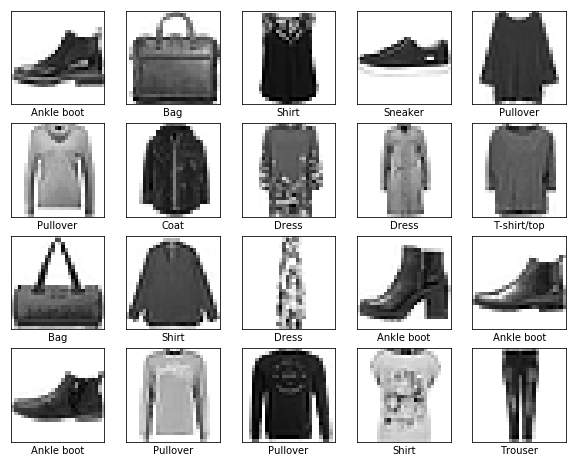

In [0]:
# We visualize 20 imqges of the data we will learn
plt.figure(figsize=(10,10))
for idx in range(20):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])

    # get a random image index
    img = np.random.randint(0, 50000)
    plt.imshow(train[img], cmap="gray_r")
    plt.xlabel(class_labels[train_labels[img]]) # print the class label for the image

## Onto some GAN Training to make those pretty pictures



Before we get into training our GAN let's define some steps:
* Process our data to get it in the correct form
* Define out GAN architecture - we need both a discriminator and generator
* Define the loss functions and optimizers for both
* Create our training loop


### Data pre-processing



We need to pre-process our data
.
1. Add an extra dimension. Why? Lots of layers will require an extra channel dimension. 
2. Normalize the images values to [-1, 1] Why? Based on the DCGAN guidelines
3. Randomize and batch the data. Why? Make training faster

In [0]:
images = np.expand_dims(train, axis=3) # add a channel dim
images = images.astype('float32') # convert to float32
images = (images - 127.5) / 127.5 # normalize the images to [-1, 1]
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(batch_size*10).batch(batch_size)

### GAN Architecture



Let's think about how our two networks must be structured. 

The *discriminator* should take a 28x28x1 array of numbers in the range [-1, 1] as its input and return a scalar between 0 and 1. This scalar will be interpreted as the probability the image came from the training dataset rather than being generated by the generator, i.e. the probability that the image is real rather than fake.

The *generator* should take a vector and return a 28x28x1 array of numbers in the range [-1, 1]. The size of the vector is the *latent dimension* and is a hyperparameter that we can tune. 

One of the most challenging parts of deep learning is choosing the architecture for our models. This issue is highlighted for GAN training, which is notoriously tricky. A GAN might work correctly with one architecture and fail to train at all with a slightly different architecture.  Furthermore, instabilities and pathologies are very common in GAN training, for example, the generator and discriminator might end up chasing each other in circles rather than converging. The good news is that GANs are an active area of research and several methods exist for making GANs train more reliably. One such method that works very well for images is the DCGAN architecture by _Radford et al._ which we will draw inspiration from to design our networks. Here are some tips from the [git repo](https://github.com/Newmu/dcgan_code) for DCGAN:



#### Tips and Tricks



* Replace any pooling layers with strided convolutions.
* Use batchnorm in both the generator and the discriminator
* Remove fully connected hidden layers for deeper architectures. Just use average pooling at the end. 
* Use ReLU activations in the generator for all layers except for the output, which uses Tanh. *(This means they are generating pixel values between -1 and 1.)*
* Use LeakyReLU activation in the discriminator for all layers.

We will use these guidelines to help us define our discriminator and generator, but you should experiment and see what happens if you make other choices.


#### Define the Generator



In [0]:
def generator():
  generator = tf.keras.Sequential(name="generator")
  
  # we start with 7 * 7 * XXX so that we can apply two blocks that include
  # UpSampling layers, which will eventually give us a 28 * 28 image, since
  # 7 * 2 * 2 = 28
  generator.add(tf.keras.layers.Dense(7 * 7 * 128,
                                activation="relu",
                                input_dim=100))

  
  generator.add(tf.keras.layers.Reshape([7, 7, 128]))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.Conv2D(1,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.Activation("tanh"))
  
  
  return generator
  
generator = generator()    

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 128)       0 

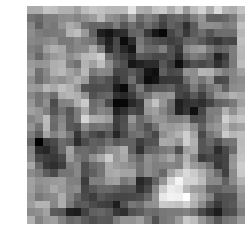

In [0]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
plt.axis('off')
plt.show()

#### Define the Discriminator





In [0]:
def discriminator():
  
  discriminator = tf.keras.Sequential(name="discriminator")
  
  discriminator.add(tf.keras.layers.Conv2D(32,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same",
                                  input_shape=(28,28,1)))

  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(64,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(128,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(256,
                                  kernel_size=3,
                                  strides=1,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Flatten())
  discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  
    
  return discriminator
  
discriminator = discriminator()    

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)        

In [0]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49996805]], shape=(1, 1), dtype=float32)


#### Loss Functions


Define the discriminator loss.

- Role of the discriminator: determine is an image fake or real ---> binary classifier
- So ideally we predict 1 for a real image and 0 for a fake.
- Cross entropy is the standard loss for binary classifiers
- So we can do cross entropy for the real and for the fake. Then combine the two losses


In [0]:
# define the loss function for the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    # real_output is the prediction of the discriminator for a batch of real images
    # fake_output is the same but for images from the generator
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Define the generator loss.

- Role of the generator is to trick the discriminator.
- So the generator loss uses the discriminators predictions i.e. to make itself better
- We train the generator to make the discrimator predict real (1) for the fake image

This is the adversarial nature - the loss functions are at odds with each other

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Since we have 2 different networks, we need 2 different optimizers. The hyper-parameters of the type of optimizer and learning rate are defined below. But feel free to play around with them - you may do better!

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop

* We train both the generator and discriminator networks
* Step 1: Generate random noise
* Step 2: Generate an image using the generator with the random noise as input
* Step 3: Pass a real image and the generated image through the discriminator
* Step 4: Compute the loss for the generator and discriminator
* Step 5: Compute the mean loss for the batch
* Step 6: Compute the gradient using the losses for both generator and discriminator 
* Step 7: Apply the optimizer to take the gradient "step"
* Step 8: Repeat till epochs completed

Note the usage of tf.GradientTape()


## Let's train the GAN

In [0]:
# if you change the definitions for the generator and/or discriminator,
# or if you want to restart training...
# RE-RUN THIS CELL!

gen_loss_mean = tf.keras.metrics.Mean(name='gen_loss_mean')
disc_loss_mean = tf.keras.metrics.Mean(name='disc_loss_mean')

@tf.function
def train_step(images):                                       
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_loss_mean(gen_loss)
    disc_loss_mean(disc_loss)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
# Exercise: why do we define this as a constant?
noise = np.random.normal(0, 1, (8, 100))

def generate_and_display_images(generator):
    predictions = generator(noise, training=False)
      
    fig = plt.figure(figsize=(16,2))

    for i in range(predictions.shape[0]):
      plt.subplot(1, 8, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray_r')
      plt.axis('off')

    plt.show()
    
def train_GAN(epochs):
  generate_and_display_images(generator)
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      
    template = 'Epoch {:03d}: time {:.3f} sec, gen loss {:.3f}, disc loss {:.3f}'
    print(template.format(epoch + 1, time.time()-start, gen_loss_mean.result(), disc_loss_mean.result()))
    
    generate_and_display_images(generator)


We will train for 20 epochs which should take 5min on the colab GPU. If you want more crisp results increase the epochs to around 50

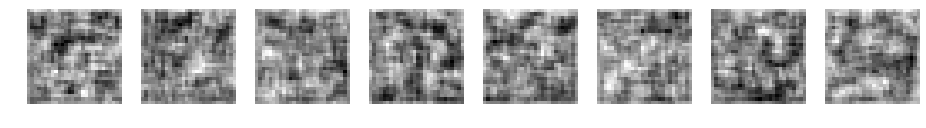

Epoch 001: time 35.852 sec, gen loss 1.870, disc loss 1.075


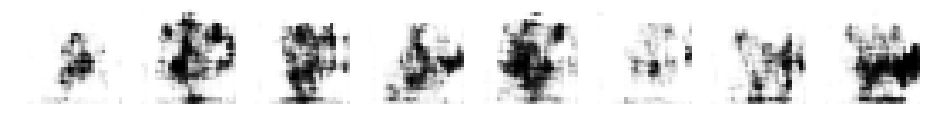

Epoch 002: time 29.115 sec, gen loss 1.976, disc loss 1.072


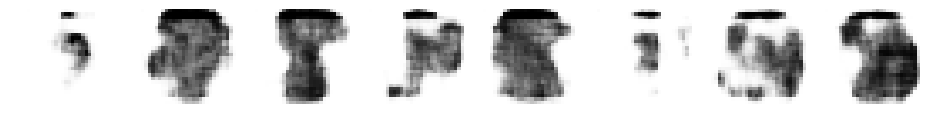

Epoch 003: time 29.023 sec, gen loss 1.863, disc loss 1.066


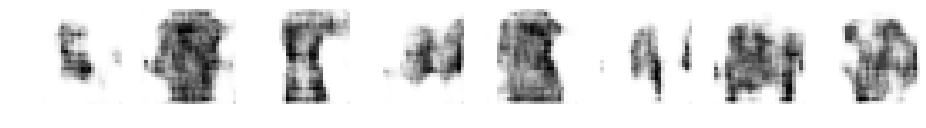

Epoch 004: time 29.008 sec, gen loss 1.777, disc loss 1.053


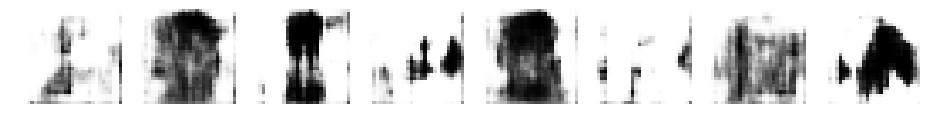

Epoch 005: time 28.974 sec, gen loss 1.782, disc loss 1.012


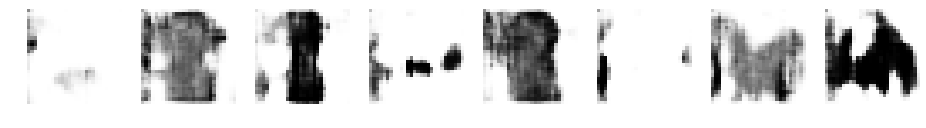

Epoch 006: time 28.971 sec, gen loss 1.809, disc loss 0.971


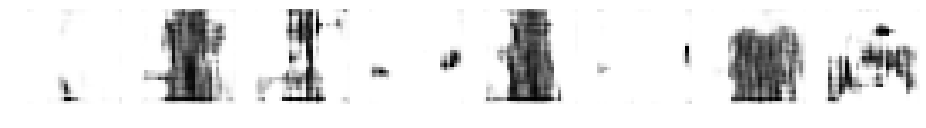

Epoch 007: time 28.970 sec, gen loss 1.813, disc loss 0.947


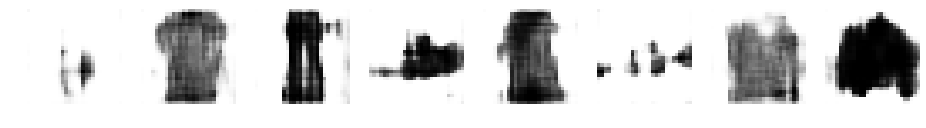

Epoch 008: time 28.956 sec, gen loss 1.802, disc loss 0.938


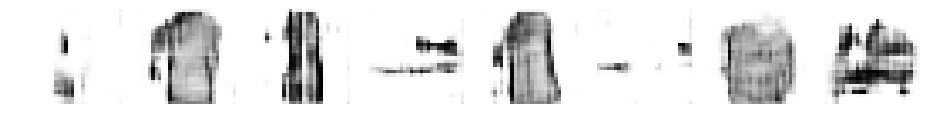

Epoch 009: time 28.934 sec, gen loss 1.804, disc loss 0.925


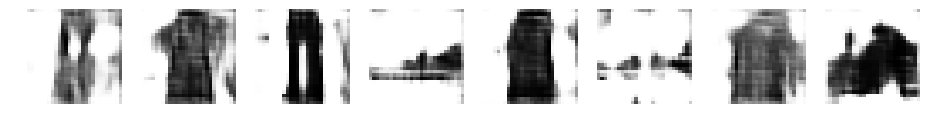

Epoch 010: time 28.923 sec, gen loss 1.811, disc loss 0.910


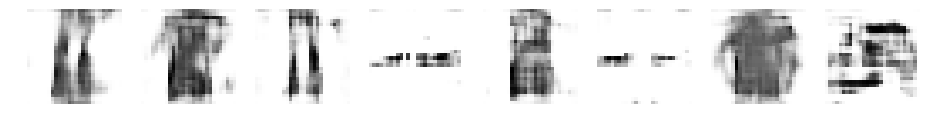

Epoch 011: time 28.947 sec, gen loss 1.813, disc loss 0.904


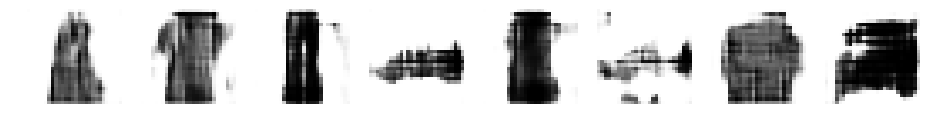

Epoch 012: time 28.974 sec, gen loss 1.814, disc loss 0.894


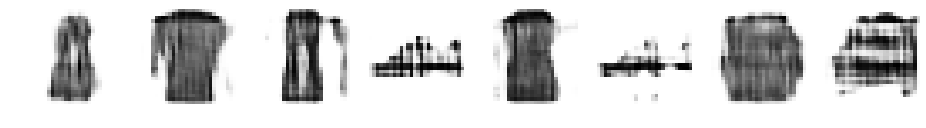

Epoch 013: time 29.004 sec, gen loss 1.815, disc loss 0.886


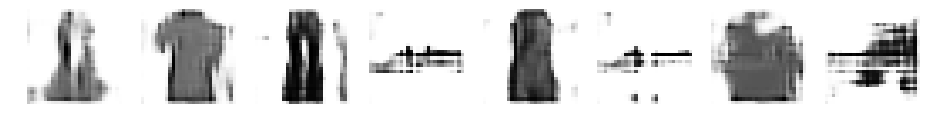

Epoch 014: time 28.939 sec, gen loss 1.817, disc loss 0.876


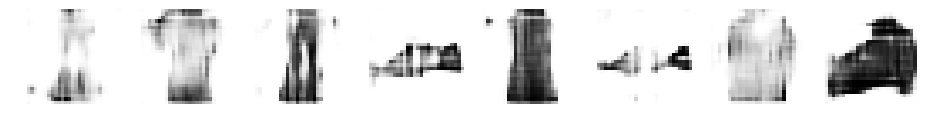

Epoch 015: time 28.931 sec, gen loss 1.821, disc loss 0.868


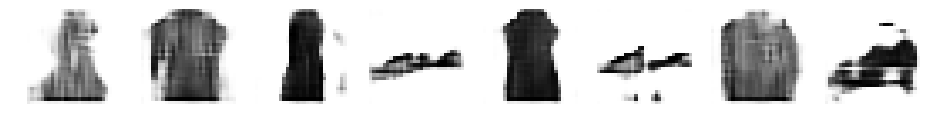

Epoch 016: time 28.978 sec, gen loss 1.827, disc loss 0.860


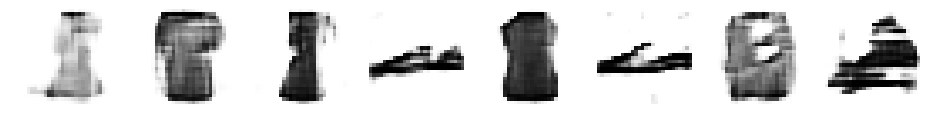

Epoch 017: time 28.988 sec, gen loss 1.823, disc loss 0.858


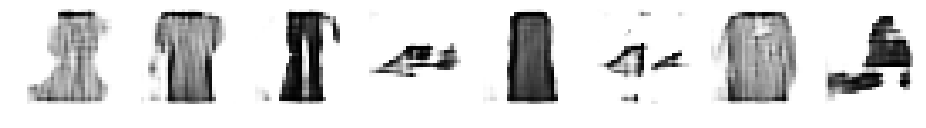

Epoch 018: time 28.966 sec, gen loss 1.817, disc loss 0.858


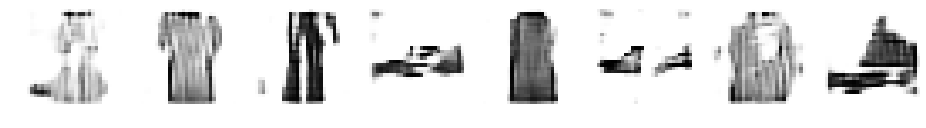

Epoch 019: time 28.938 sec, gen loss 1.811, disc loss 0.859


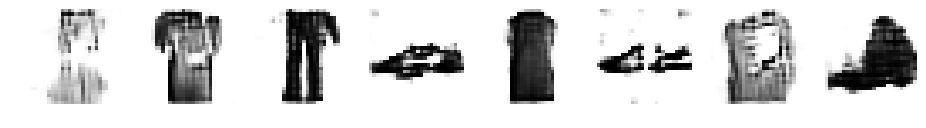

Epoch 020: time 28.901 sec, gen loss 1.804, disc loss 0.859


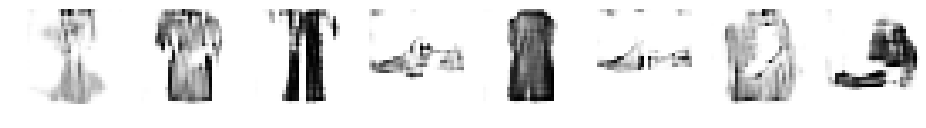

Epoch 021: time 28.881 sec, gen loss 1.796, disc loss 0.861


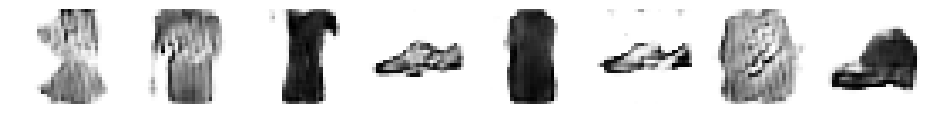

Epoch 022: time 28.928 sec, gen loss 1.788, disc loss 0.863


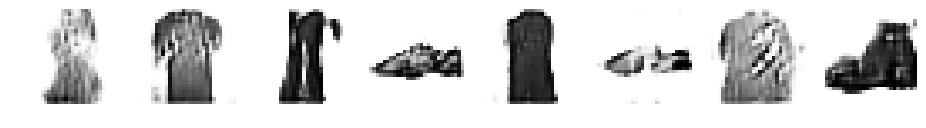

Epoch 023: time 28.874 sec, gen loss 1.778, disc loss 0.869


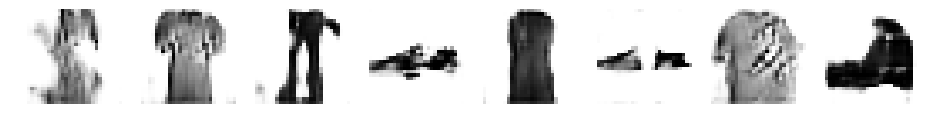

Epoch 024: time 28.930 sec, gen loss 1.768, disc loss 0.873


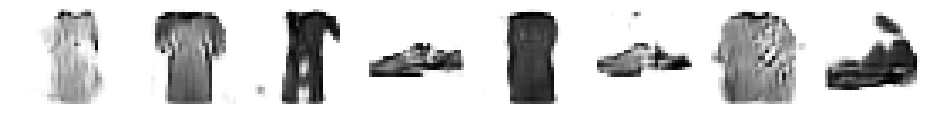

Epoch 025: time 28.936 sec, gen loss 1.758, disc loss 0.877


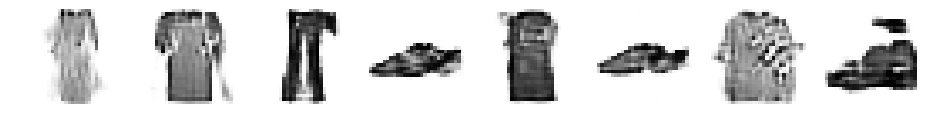

Epoch 026: time 28.972 sec, gen loss 1.747, disc loss 0.881


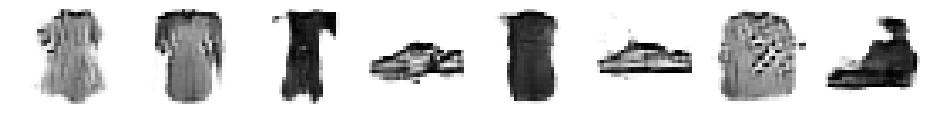

Epoch 027: time 28.978 sec, gen loss 1.738, disc loss 0.884


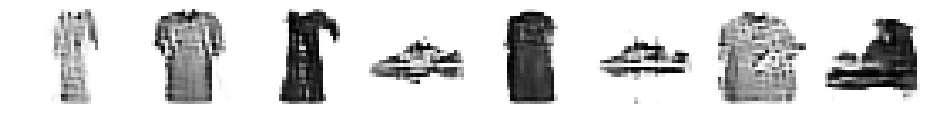

Epoch 028: time 28.986 sec, gen loss 1.730, disc loss 0.887


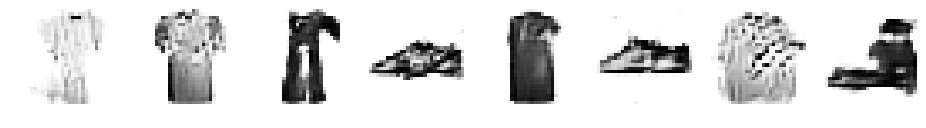

Epoch 029: time 28.935 sec, gen loss 1.721, disc loss 0.890


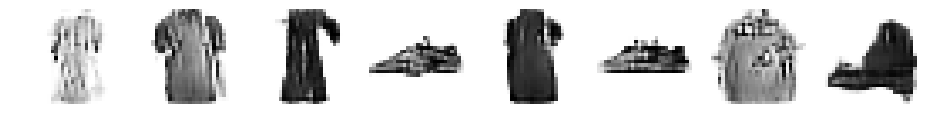

Epoch 030: time 28.921 sec, gen loss 1.713, disc loss 0.893


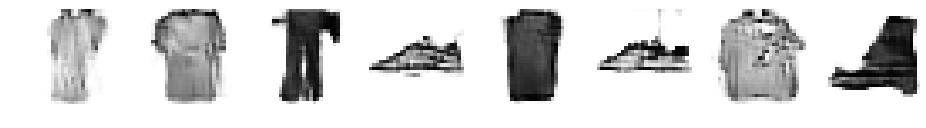

Epoch 031: time 29.034 sec, gen loss 1.706, disc loss 0.895


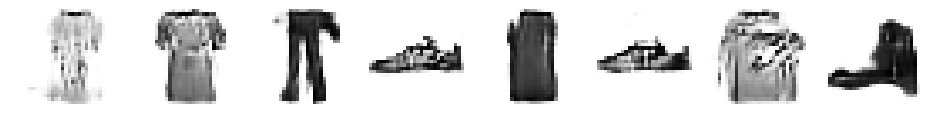

Epoch 032: time 28.938 sec, gen loss 1.696, disc loss 0.900


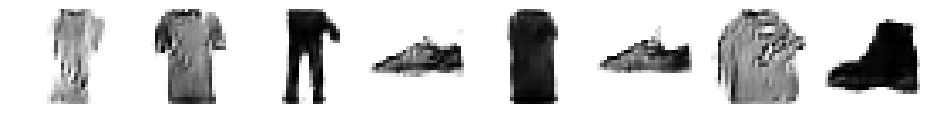

Epoch 033: time 28.953 sec, gen loss 1.690, disc loss 0.901


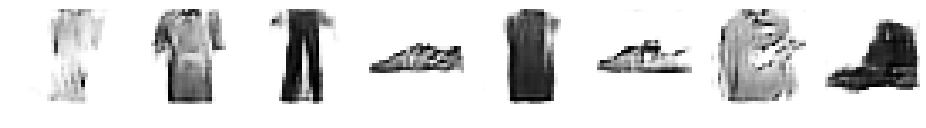

Epoch 034: time 28.964 sec, gen loss 1.682, disc loss 0.904


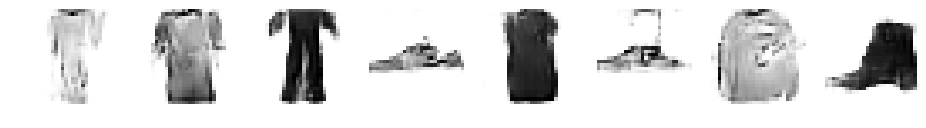

Epoch 035: time 28.934 sec, gen loss 1.676, disc loss 0.906


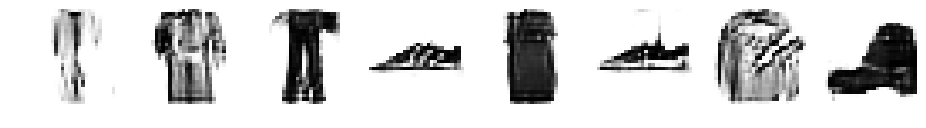

Epoch 036: time 28.919 sec, gen loss 1.673, disc loss 0.906


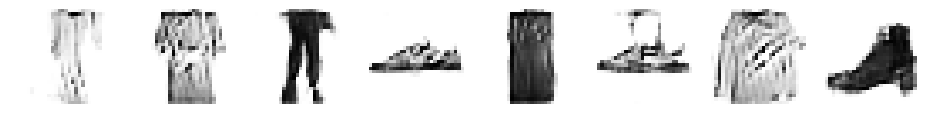

Epoch 037: time 28.912 sec, gen loss 1.667, disc loss 0.908


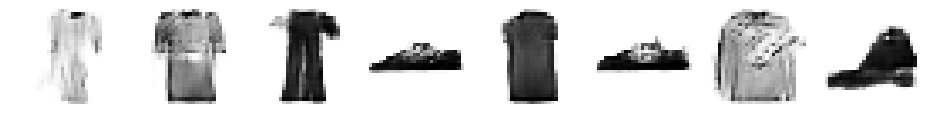

Epoch 038: time 28.938 sec, gen loss 1.663, disc loss 0.909


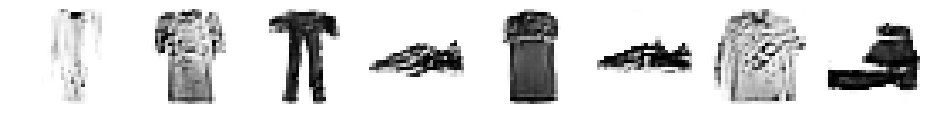

Epoch 039: time 28.930 sec, gen loss 1.655, disc loss 0.912


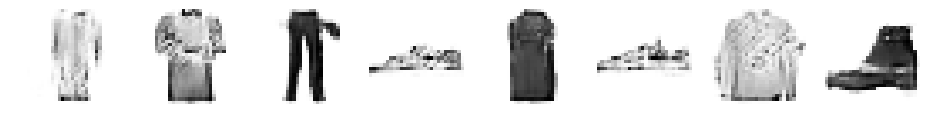

Epoch 040: time 28.942 sec, gen loss 1.652, disc loss 0.913


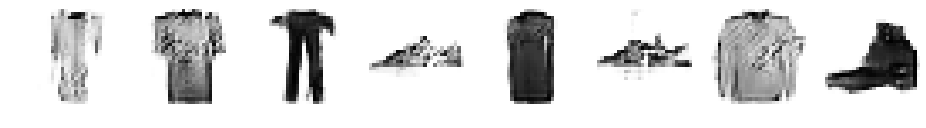

Epoch 041: time 28.922 sec, gen loss 1.646, disc loss 0.916


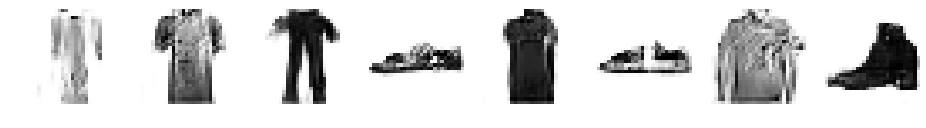

Epoch 042: time 28.943 sec, gen loss 1.641, disc loss 0.917


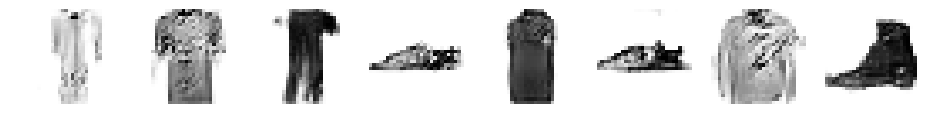

Epoch 043: time 28.926 sec, gen loss 1.636, disc loss 0.918


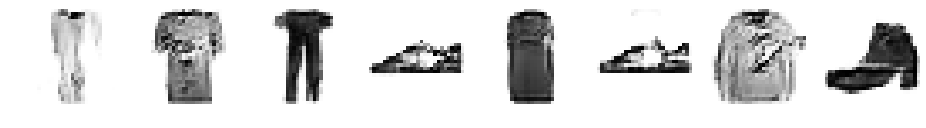

Epoch 044: time 28.921 sec, gen loss 1.631, disc loss 0.920


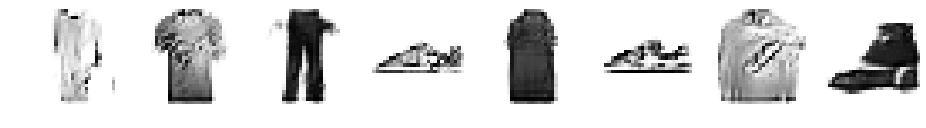

Epoch 045: time 28.945 sec, gen loss 1.627, disc loss 0.922


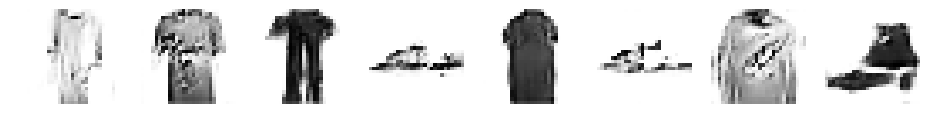

Epoch 046: time 28.912 sec, gen loss 1.623, disc loss 0.923


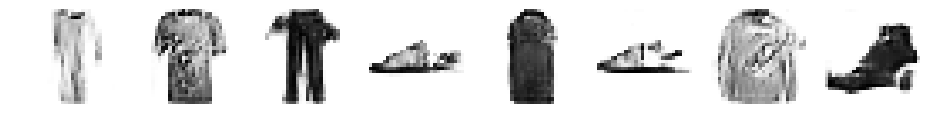

Epoch 047: time 28.949 sec, gen loss 1.618, disc loss 0.924


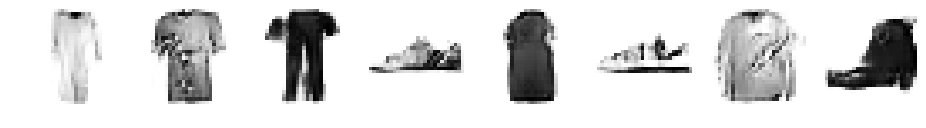

Epoch 048: time 28.940 sec, gen loss 1.614, disc loss 0.926


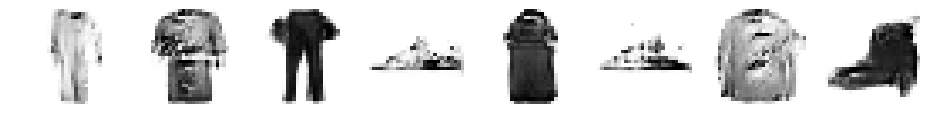

Epoch 049: time 28.932 sec, gen loss 1.610, disc loss 0.927


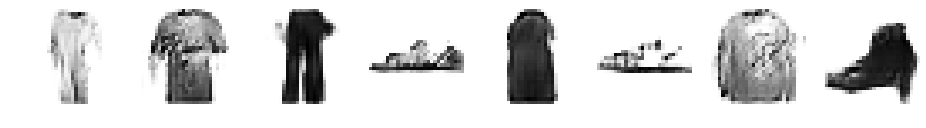

Epoch 050: time 28.941 sec, gen loss 1.607, disc loss 0.928


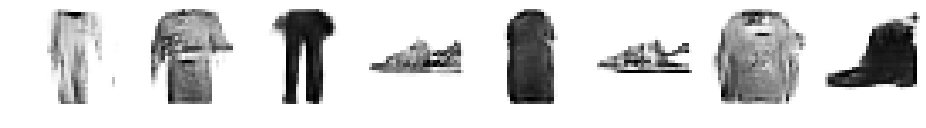

In [0]:
num_epochs = 50
train_GAN(num_epochs)

We go from the generator making images which are just noise- to actually producing "new" and real looking images of the Fashion MNIST clothes. This means the network has learned $p(x)$

## Common Problems?

https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775
https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b
https://developers.google.com/machine-learning/gan/problems
https://hub.packtpub.com/challenges-training-gans-generative-adversarial-networks/

## Further